# Trabajo práctico 1

Integrantes:
- Alvarez Vico Jazmín
- Cortes Conde Tito Maria Javier
- Frassia Fernando Nicolas


## Aclaraciones preliminares

### Sobre la hipótesis nula
Se define hipótesis nula como la proposición de que dos fenómenos medidos no están relacionados.
Al rechazar la hipótesis nula podemos decir inferir que es probable que dicha relación exista.

### Sobre el p valor
El p valor nos indica la probabilidad de obtener un valor igual o más extremo al obtenido a través de una medición, asumiendo cierta la hipótesis nula.

Al obtener un p valor chico (tradicionalmente se considera chico un p valor menor o igual a 0,05) rechazamos la hipótesis nula. Pues esto significa que es poco probable obtener un resultado semejante con un espacio muestral distinto al que tenemos.

En esta caso, decimos que nuestra muestra es estadísticamente significativa, reforzando nuestra hipótesis alternativa. 

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

## Funciones auxiliares

In [2]:
def igual_varianza(l1,l2):
    estadistico = np.var(l1) / np.var(l2) 
    pval=  sp.stats.f.cdf(estadistico,len(l1)-1, len(l2)-1)
    print("pval = " + str(pval))
    return pval>=0.05

def distribucion_normal(l1):
    pval = sp.stats.shapiro(l1)[1]
    val = pval >= 0.05
    if val:
        print("no se sabe la distribución")
    else:
        print("distribución no normal")
    print("pval = " + str(pval))
    return val

def test_permutaciones(l1,l2,cant_permutaciones):
    
    meanl1 = np.mean(l1)
    meanl2 = np.mean(l2)
    l1 = [x for x in l1]
    l2 = [x for x in l2]
    muestra = l1+l2
    il1 = len(l1)-1
    delta=[] 
    delta.append(meanl2-meanl1)

    for i in range(0,cant_permutaciones):

        random.shuffle(muestra)
        currentDelta = np.mean(muestra[:il1+1]) - np.mean(muestra[il1+1:])
        delta.append(currentDelta)

    aux = 1
    for i in range(1,len(delta)):
        if delta[0] <= delta[i]:
            aux += 1
    pval = aux/len(delta)
    
    plt.axvline(x=delta[0], color='r')
    plt.hist(delta)
    plt.show()
    print("p value = " + str(pval)) 

    
def  wilcoxon_apareadas(l1,l2):
    pval= sp.stats.wilcoxon(l1,l2)[1]
    print("p value = " + str(pval))
    
def igual_media_apareada(l1,l2,cant_permut): 
    if distribucion_normal(l1) and distribucion_normal(l2):
        print("checkeo distribución normal: No concluyente, suponemos normalidad")
        ig_var = igual_varianza(l1,l2)
        ig_var2 = igual_varianza(l2,l1)
        if (ig_var and ig_var2):            
            print("checkeo varianza: No concluyente, suponemos igual varianza")
            print("utilizamos test de Student")
            pval = sp.stats.ttest_rel(l1, l2)[1]
            print("p value = " + str(pval) )
        else:
            print("checkeo varianza: NO")
            print("utilizamos test de Welsh")
            pval = sp.stats.ttest_ind(l1, l2)[1]
            print("p value = " + str(pval) )
            
    print("utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal")
    wilcoxon_apareadas(l1,l2)
            
def igual_media_1muesrta(l):
    if distribucion_normal(l):
        print("checkeo distribución normal: ok") 
        meanl = np.mean(l)
        pval = sp.stats.ttest_1samp(l,meanl)[1]
        print("p value = " + str(pval) )
    

    
def anova2ways():
    df=DataFrame()
    df.read_tbl('tiempos.txt')
    df['id'] = xrange(len(df['len']))
 
    print(df.anova('len', sub='id', bfactors=['supp', 'dose']))

#divide por tres por que quiero el promedio, es una funcion muy especifica usarla con quidado
def sumLista(l1, l2):
    l3 =[]
    for i in range(len(l1)):
        l3.append((l1[i] +l2[i])/3.0)
    
    return l3
    



## Lectura de datos

In [4]:
df = pd.read_csv('tiempos.txt', sep=' ')

## Gráficos preliminares

/Users/fer/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


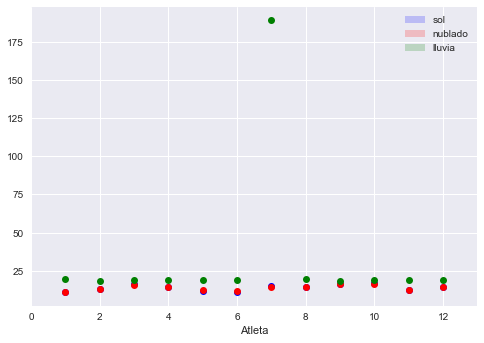

In [5]:
sol = sns.tsplot(time=df['Atleta'], data=df['tiempo_sol'], interpolate=False, color="blue")

nublado = sns.tsplot(time=df['Atleta'], data=df['tiempo_nublado'], interpolate=False, color="red")

lluvia = sns.tsplot(time=df['Atleta'], data=df['tiempo_lluvia'], interpolate=False, color="green")

sns.plt.legend([sol, nublado, lluvia], labels=["sol","nublado","lluvia"])

sns.plt.show()


podemos observar que un dato tiene un valor "extraño", tiene un valor mucho mayor a los demas. Suponemos que se debe a un error de tipeo.


## Limpieza

### Decisiones
Tomamos la decisión de borrar de las muestras al corredor cuyo valor era por demás superior al resto del grupo. Notemos que borramos su muestra de todos los días, para que la cantidad de muestras por días sea equitativa.


/Users/fer/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


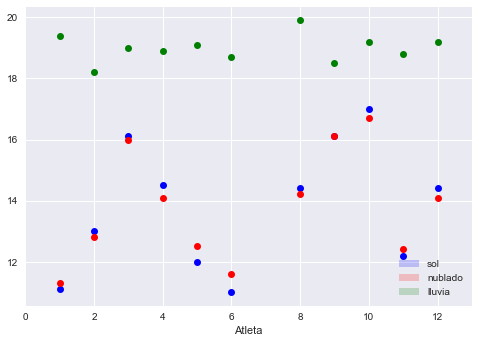

In [6]:
df.drop(df[df.tiempo_lluvia > 180.0].index, inplace=True)

sol = sns.tsplot(time=df['Atleta'], data=df['tiempo_sol'], interpolate=False, color="blue")

nublado = sns.tsplot(time=df['Atleta'], data=df['tiempo_nublado'], interpolate=False, color="red")

lluvia = sns.tsplot(time=df['Atleta'], data=df['tiempo_lluvia'], interpolate=False, color="green")

sns.plt.legend([sol, nublado, lluvia], labels=["sol","nublado","lluvia"])

sns.plt.show()


## Análisis de Datos

## Hipótesis: Los atletas son más lentos en días de lluvias que en días soleados.

## Hipótesis nula: Los atletas son igual o más rápidos en días de lluvia que en días soleados.

Para probar esto utilizaremos el test de wilcoxon de rank-sum, que como hipotesis nula dice que las muestras vienen de una misma distribución. Si se rechaza esto, sabremos que no son iguales, pero no sabremos cuando es que los atletas son son mas rapidos que los otros. por esto usaremos un test de permutaciones para tratar de rechazar la totalidad de la hipotesis nula.

no se sabe la distribución
pval = 0.42219114303588867
no se sabe la distribución
pval = 0.9883151650428772
checkeo distribución normal: No concluyente, suponemos normalidad
pval = 0.999978436181
pval = 2.15638186198e-05
checkeo varianza: NO
utilizamos test de Welsh
p value = 1.04961025807e-07
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.00334561811585


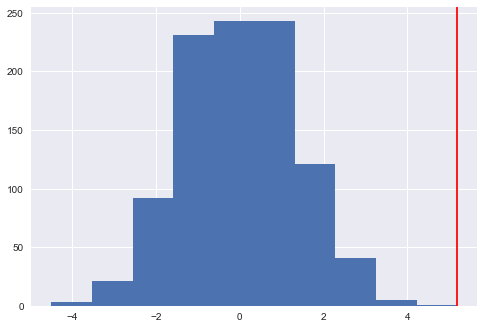

p value = 0.000999000999000999


In [6]:
#igual_media_apareada(df['tiempo_sol'], df['tiempo_lluvia'],1000)
aux = sp.stats.ranksums(df['tiempo_sol'], df['tiempo_lluvia'])
print("p value = "+str(aux[1]))
test_permutaciones(df['tiempo_sol'],df['tiempo_lluvia'],1000)




podemos observar que de ambos tests obtenemos p valores pequños, a raíz de esto podemos rechazar ambas partes de nuestra hipótesis nula, validando nuestra hipótesis alternativa. Es decir, los atletas son más lentos en días de lluvia que en días soleados.



## Hipótesis nula: El cielo nublado no influye en los tiempos de los atletas 

### Análisis de distribución

Para empezar, queremos saber si nuestro muestreo sigue una distribución normal. Eso nos puede dar cierta información sobre cómo son los datos.
Para esto, usaremos el test de Shapiro-Wilks:

In [7]:
distribucion_normal([x for x in df['tiempo_sol']])
distribucion_normal([x for x in df['tiempo_nublado']])

no se sabe la distribución
pval = 0.42219114303588867
no se sabe la distribución
pval = 0.3774447739124298


True

Como podemos ver, en ambas muestras el test dio un p valor mayor a 0,05. Esto quiere decir que no podemos rechazar su hipótesis nula, que es que las muestras no tienen distribución normal; entonces no tenemos herramientas suficientes como para determinar sus distribuciones.

### Análisis de varianza

También nos interesa saber si las muestras en días de sol y las de días nublados tienen la misma varianza, para saber qué tipos de test podemos realizar luego.

In [8]:
igual_varianza([x for x in df['tiempo_sol']], [x for x in df['tiempo_lluvia']])

pval = 0.999978436181


True

Al igual que el análisis de la distribución, el análisis de la varianza es inconcluyente - siendo el p valor del F-test (0,99) mayor a 0,05.

### Tests

Dado que los análisis de distribución y varianza fueron inconcluyentes, nos queda separar en casos de distintas asunciones y realizar los tests correspondientes.

#### Asumiendo distribución normal e igual varianza

Dadas las respectivas asunciones y que además tenemos muestras independientes, estamos en condiciones de utilizar un test paramétrico, en particular nos interesa el test de Student de dos colas. 

Su hipótesis nula es que ambas muestras tienen la misma media; quisieramos rechazar esa hipótesis para así rechazar nuestra hipótesis nula.

In [9]:
igual_media_apareada(df['tiempo_sol'], df['tiempo_nublado'], 1000)

no se sabe la distribución
pval = 0.42219114303588867
no se sabe la distribución
pval = 0.3774447739124298
checkeo distribución normal: No concluyente, suponemos normalidad
pval = 0.638810011712
pval = 0.361189988288
checkeo varianza: No concluyente, suponemos igual varianza
utilizamos test de Student
p value = 1.0
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.959221134457


Ahora bien, no sólo el p valor del test fue mayor a 0,05 sino que fue 1, lo cual es bastante interesante. 

#### Asumiento que no tienen distribución normal ni igual varianza

Ahora, dado que asumimos que no tienen distribución normal, ni igual varianza, nos queda realizar un test no paramétrico. Podemos usar un test de Wilcoxon de dos colas, que analiza la distribución de las diferencias entre ambos días.

test wilcoxon

Nuevamente, el p valor es mayor a 0,05 (0,95), con lo cual no podemos concluir mucho del mismo. 

### Test de permutaciones

Por otro lado, podemos hacer un test de permutaciones para ver qué tan probable es tener nuestra muestra suponiendo que la hipótesis nula es verdadera.

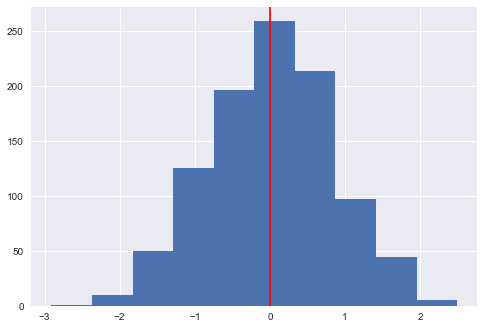

p value = 0.5024975024975025


In [11]:
test_permutaciones(df['tiempo_sol'], df['tiempo_nublado'], 1000)

Como el p valor es mayor a 0,05, no tenemos información suficiente como para rechazar H0.

### Conclusiones

Los tests fueron no concluyentes, con lo cual no podemos rechazar la hipótesis nula, sólo podemos decir que no tenemos suficiente información como para hacerlo.
Por otro lado, es interesante notar que el test de student y el de Wilcoxon dieron p valor superior a 0,95; lo cual nos dice que hay un gran factor de aliatoriedad en nuestras muestras.

# Hipótesis: el clima influye en la velocidad del atleta.

## Hipótesis Nula: el clima no influye en la velocidad del atleta. 

⁠⁠⁠Para decidir si el clima  influye en la velocidad de los atletas, basta con ver que existe una diferencia estadística entre los tiempos medidos en dos climas distintos. 
En los tests anteriores analizamos dos casos “nublado-sol” y “sol-lluvia”. 
En el primer caso no pudimos sacar conclusiones de que dicha afección sea cierta, sin embargo en el segundo caso, pudimos concluir que era altamente probable que la lluvia afectara el tiempo de los atletas. 
A raíz de esto, podemos decir entonces que efectivamente el clima afecta a los atletas.

# Hipótesis: la velocidad en días de lluvia es independiente del atleta

## hipotesis nula: la velocidad en días de lluvia depende del atleta.

Para testear nuestra hipotesis nula vamos a crear un test de permutaciones con una nueva variable aleatoria, esta se define como el promedio en tiempos de un atleta, es decir vamos a sumar los tiempos de cada atleta en los distintos climas y sacar su promedio.Esta va a ser nuestra nueva variable aleatoria.
Luego vamos a permutar las velocidades en dias de lluvia y volveremos a caluclar el promedio.
si nos da un p valor muy bajo entonces la descartaremos, respaldando nuestra hipotesis nula. 

# Consejos al entrenador:
1- Recomendamos que los atletas entrenen en días de lluvia, ya que sostenemos que hay altas probabilidades de que los atletas sean más lentos en estos días, de esta forma creemos que el entrenamiento tendra mejor rendimiento.
2- Recomendamos que al poner fechas de competencia se busque evitar dias de lluvia.
